In [1]:
from spectra import Spectra, SpectraDataset
from torchdrug import datasets
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm import tqdm
from tdc.single_pred import Tox
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem

# SPECTRA Small Molecule Tutorial

### We take an example small molecule property prediction dataset from the Therapeutic Data Commons, the hERG toxicity dataset
### We define a continuous spectral property based on the tanimoto similarity between two small molecules.
### We define cross-split overlap as average tanimoto similarity in the test versus the train

In [2]:
class TDC_Toxicity_Dataset(SpectraDataset):
    
    def parse(self, input_file):
        return Tox(name = input_file).get_data()['Drug'].unique()
    
    def __len__(self):
        return len(self.samples)
    
    def sample_to_index(self, sample):
        if not hasattr(self, 'index_to_sequence'):
            print("Generating index to sequence")
            self.index_to_sequence = {}
            for i in tqdm(range(len(self))):
                x = self.__getitem__(i)
                self.index_to_sequence[x] = i

        return self.index_to_sequence[sample] 

    def __getitem__(self, idx):
        return self.samples[idx]

In [3]:
class SPECTRA_TDC_Toxicity(Spectra):

    def spectra_properties(self, sample_one, sample_two):
        mol1 = Chem.MolFromSmiles(sample_one)
        mol2 = Chem.MolFromSmiles(sample_two)

        fp1 = AllChem.GetMorganFingerprintAsBitVect(mol1, 2)
        fp2 = AllChem.GetMorganFingerprintAsBitVect(mol2, 2)
        
        return DataStructs.TanimotoSimilarity(fp1, fp2)

    def cross_split_overlap(self, train, test):
        average_similarity = []

        for i in test: 
            for j in train:
                average_similarity.append(self.spectra_properties(self.dataset.sample_to_index(i), self.dataset.sample_to_index(j)))

        return np.mean(average_similarity)

In [4]:
TDC_Dataset = TDC_Toxicity_Dataset('hERG', 'hERG')

Found local copy...
Loading...
Done!


In [5]:
tdc_spectra = SPECTRA_TDC_Toxicity(TDC_Dataset, binary = False)

In [6]:
tdc_spectra.pre_calculate_spectra_properties('tdc_herg')

File tdc_herg_precalculated_spectra_properties already exists, set force_recalculate to True to recalculate


In [7]:
spectra_parameters = {'number_repeats': 3, 
                      'random_seed': [42, 44, 46],
                      'spectral_parameters': ["{:.2f}".format(i) for i in np.arange(0, 1.05, 0.05)],
                      'force_reconstruct': True,
                                              }

tdc_spectra.generate_spectra_splits(**spectra_parameters)

  0%|          | 0/209628 [00:00<?, ?it/s]

100%|██████████| 209628/209628 [00:00<00:00, 225711.26it/s]


Stats for SPECTRA property graph (SPG)
Number of nodes: 648
Number of edges: 208910
Number of connected components: 1


Generating SPECTRA split for spectral parameter 0.0 and dataset hERG
Number of samples in independent set: 648
Train size: 518	Test size: 130
Generating index to sequence


100%|██████████| 648/648 [00:00<00:00, 401701.00it/s]


Cross split overlap: 0.106095014360649



Generating SPECTRA split for spectral parameter 0.0 and dataset hERG
Number of samples in independent set: 648
Train size: 518	Test size: 130
Cross split overlap: 0.10704729317174556



Generating SPECTRA split for spectral parameter 0.0 and dataset hERG
Number of samples in independent set: 648
Train size: 518	Test size: 130
Cross split overlap: 0.10694067858296673



Generating SPECTRA split for spectral parameter 0.05 and dataset hERG
Number of samples in independent set: 431
Train size: 344	Test size: 87
Cross split overlap: 0.0981355031222154



Generating SPECTRA split for spectral parameter 0.05 and dataset hERG
Number of samples in independent set: 433
Train size: 346	Test size: 87
Cross split overlap: 0.09424985824086049



Generating SPECTRA split for spectral parameter 0.05 and dataset hERG
Number of samples in independent set: 425
Train size: 340	Test size: 85
Cross split overlap: 0.09717023379321056



Generating SPECTRA split for 

[]

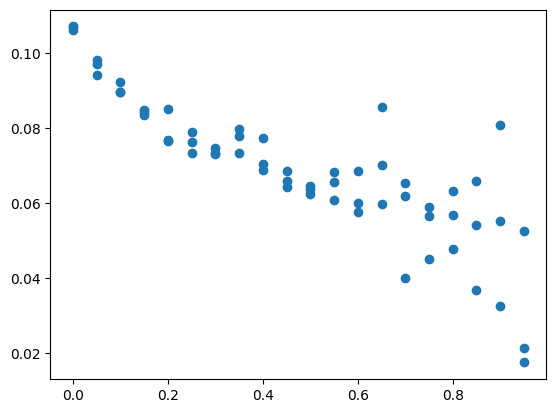

In [8]:
stats = tdc_spectra.return_all_split_stats()
plt.scatter(stats['SPECTRA_parameter'], stats['cross_split_overlap'])

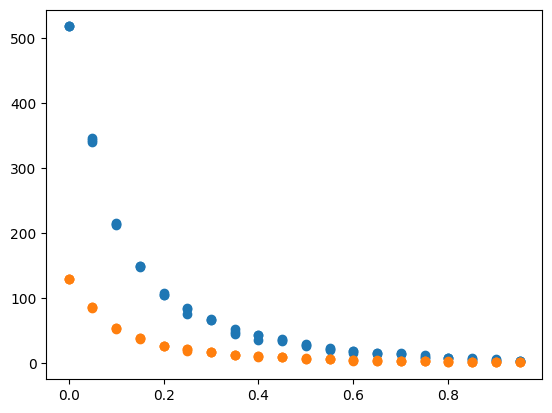

In [9]:
plt.scatter(stats['SPECTRA_parameter'], stats['train_size'])
plt.scatter(stats['SPECTRA_parameter'], stats['test_size']) 